In [108]:
# All imported libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from keras.layers import Dense, Flatten
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

In [129]:
# Function that loads all required data in its own np array.
def load_and_preprocess_dataset():
    x_train = []
    y_train = []
    data = os.listdir('CarsSet/DATA/DATA/train')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/train', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_train.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/train', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_train.append(bbox)
    
    
    x_val = []
    y_val = []
    data = os.listdir('CarsSet/DATA/DATA/validate')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/validate', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_val.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/validate', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_val.append(bbox)


    x_test = []
    y_test = []
    data = os.listdir('CarsSet/DATA/DATA/test')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/test', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_test.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/test', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_test.append(bbox)

    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)


In [130]:
# Load and preprocess the dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_and_preprocess_dataset()

In [97]:
# Get the input shape from X_train
input_shape = X_train.shape[1:]

# Load VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a flatten layer and a dense layer for classification
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='linear')(x)

# Create a new model with input and output layers
model = Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


In [98]:
# Train the model
hist = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_data=(X_val, Y_val))

Train on 269 samples, validate on 28 samples
Epoch 1/20
269/269 [==============================] - 47s 176ms/step - loss: 42245.2706 - mean_squared_error: 42245.2706 - val_loss: 18877.0645 - val_mean_squared_error: 18877.0645
Epoch 2/20
269/269 [==============================] - 41s 153ms/step - loss: 16507.2602 - mean_squared_error: 16507.2602 - val_loss: 9461.1123 - val_mean_squared_error: 9461.1123
Epoch 3/20
269/269 [==============================] - 41s 153ms/step - loss: 4862.1485 - mean_squared_error: 4862.1485 - val_loss: 3089.6052 - val_mean_squared_error: 3089.6052
Epoch 4/20
269/269 [==============================] - 41s 153ms/step - loss: 2482.2264 - mean_squared_error: 2482.2264 - val_loss: 1833.4718 - val_mean_squared_error: 1833.4718
Epoch 5/20
269/269 [==============================] - 41s 153ms/step - loss: 866.0621 - mean_squared_error: 866.0621 - val_loss: 784.9808 - val_mean_squared_error: 784.9808
Epoch 6/20
269/269 [==============================] - 41s 153ms/step

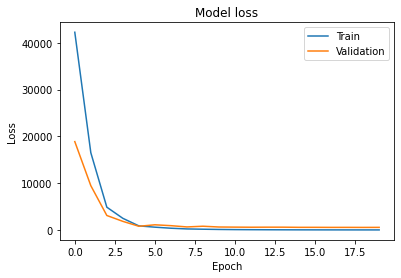

In [112]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [101]:
# Save the model
model.save("improved_model.h5")

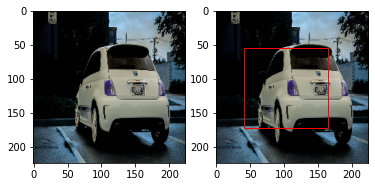

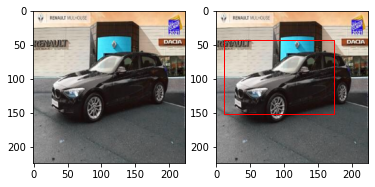

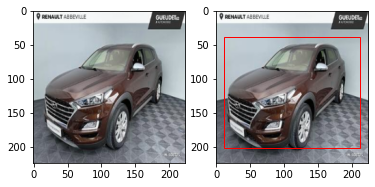

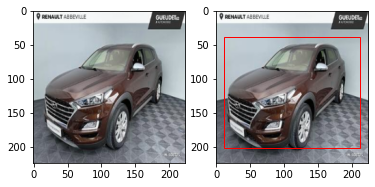

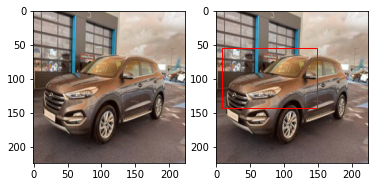

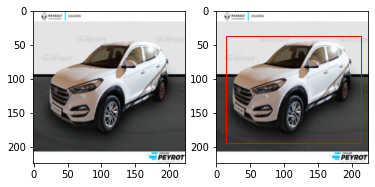

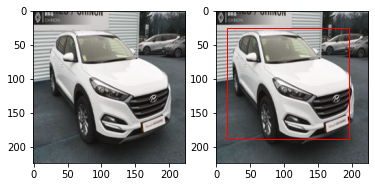

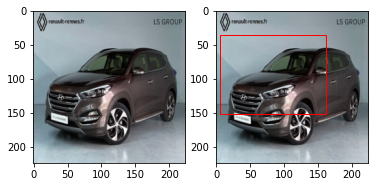

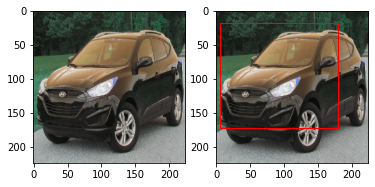

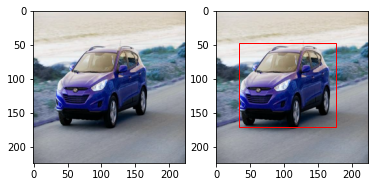

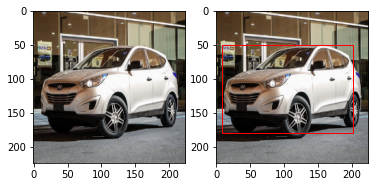

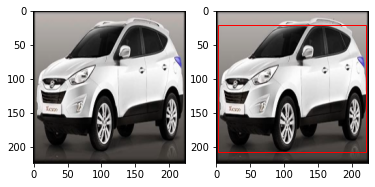

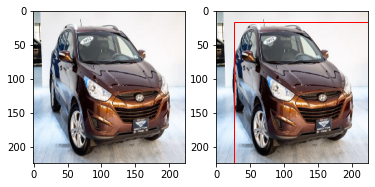

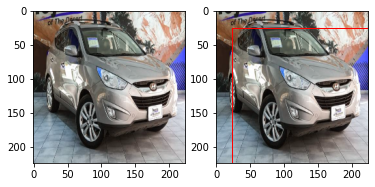

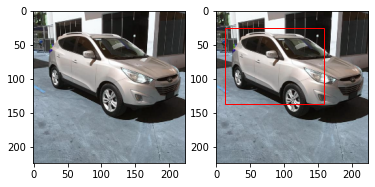

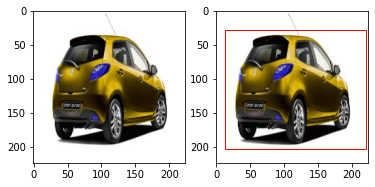

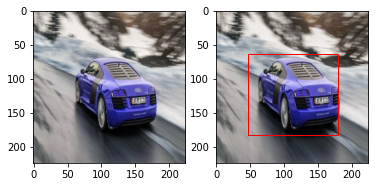

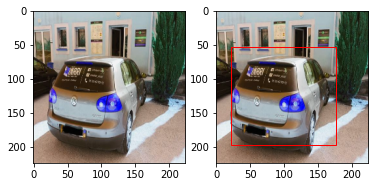

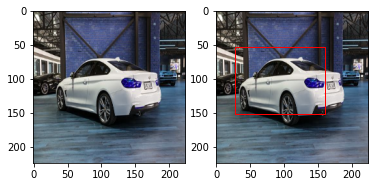

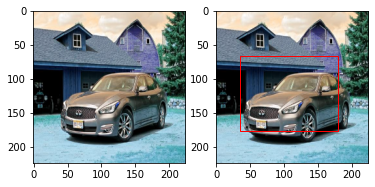

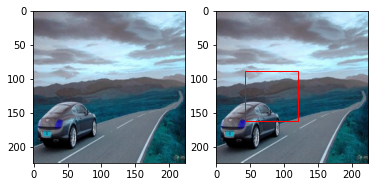

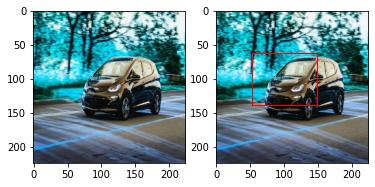

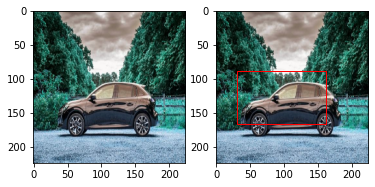

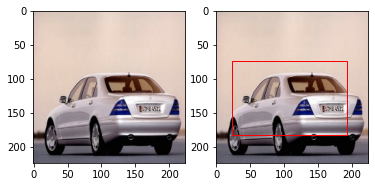

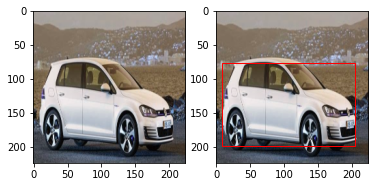

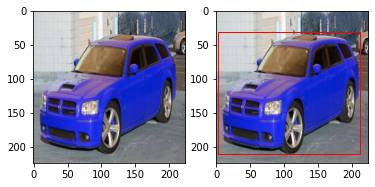

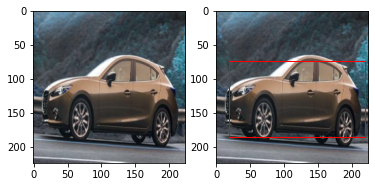

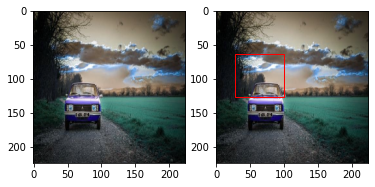

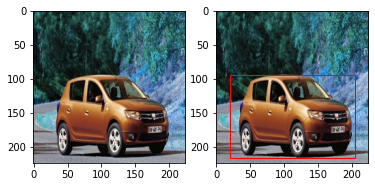

In [131]:
# Display one image without and one image with bounding boxes.
def display_image(path, x1, y1, x2, y2):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(path)
    ax[1].imshow(path)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
    plt.show()


# Loop through the image filenames and process each image
for index in range(len(X_test)):
    image = np.expand_dims(X_test[index], axis=0)
    preds = model.predict(image)
    x1, y1, x2, y2 = preds.astype('int')[0]
    display_image(X_test[index], x1, y1, x2, y2)
